In [1]:
import numpy as np
import csv
from cqs.object import Instance
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.random import random_circuit
import qiskit.qasm3 as qasm3
from instances_b.reader_b import read_csv_b
from transpiler.transpile import transpile_circuit
from examples.benchmark.cqs_simulation import main_prober, main_solver
from qiskit.quantum_info import Operator
from tqdm import tqdm
from cqs.local.calculation import __estimate_V_dagger_V,__estimate_q,__reshape_to_Q_r
from cqs.optimization import solve_combination_parameters
from matplotlib import pyplot as plt

def normalize_quantum_state(vec):
    norm=np.sqrt(np.abs(vec.T.conjugate()@vec))
    return vec/norm

def __num_to_pauli_list(num_list):
    paulis = ['I', 'X', 'Y', 'Z']
    pauli_list = [paulis[int(i)] for i in num_list]
    return pauli_list

def __add_Pauli_gate(qc, which_qubit, which_gate):
    if which_gate == 0:
        qc.id(which_qubit)
    elif which_gate == 1:
        qc.x(which_qubit)
    elif which_gate == 2:
        qc.y(which_qubit)
    elif which_gate == 3:
        qc.z(which_qubit)
    else:
        return ValueError("Not supported Pauli gate type.")

def __num_to_pauli_circuit(num_list):
    n = len(num_list)
    num_list = [int(i) for i in num_list]
    qr = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qr)
    for i in range(n):
        __add_Pauli_gate(qc, i, num_list[i])
    return qc

def create_random_circuit_in_native_gate(n, d):
    ub = random_circuit(num_qubits=n,max_operands=2, depth=d, measure=False)
    # ub = transpile_circuit(ub, device='Aria', optimization_level=2)
    return ub

In [2]:
with open('3_qubit_data_generation_matrix_A.csv', 'r', newline='') as csvfile:
    data_b = read_csv_b(3)
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for i, row in enumerate(reader):
        if 2 > i > 0:
            row_clean = [j for j in ''.join(row).split('"') if j != ',']
            nLc = row_clean[0].split(',')
            n = int(nLc[0])
            print("qubit number is:", n)
            L = int(nLc[1])
            print("term number is:", L)
            kappa = float(nLc[2])
            print('condition number is', kappa)
            pauli_strings = [__num_to_pauli_list(l) for l in eval(row_clean[1])]
            print('Pauli strings are:', pauli_strings)
            pauli_circuits = [__num_to_pauli_circuit(l) for l in eval(row_clean[1])]
            coeffs = [float(i) for i in eval(row_clean[2])]
            print('coefficients are:', coeffs)
            print()

            # circuit depth d
            d = 3
            ub = qasm3.loads(data_b.iloc[i].qasm)
            print('Ub is given by:', data_b.iloc[i].b)
            print(ub)

            # generate instance
            instance = Instance(n, L, kappa)
            instance.generate(given_coeffs=coeffs, given_unitaries=pauli_circuits, given_ub=ub)
            Itr, LOSS, ansatz_tree = main_prober(instance, backend='qiskit-noiseless',ITR=None,
                                    shots=0, optimization_level=2,
                                    noise_level_two_qubit=0, noise_level_one_qubit=0, readout_error=0)
            print(Itr)
            print(LOSS)
            print('ANsatz tree contains:')
            # for qc in ansatz_tree:
            #     print(qc)
ansatz_tree=[ansatz_tree[i] for i in range(len(ansatz_tree)-1)]

Resolved file path: C:\Users\Nikita\PycharmProjects\CQS_singapore\instances_b\3_b_random_circuits.csv
Reading file: C:\Users\Nikita\PycharmProjects\CQS_singapore\instances_b\3_b_random_circuits.csv
qubit number is: 3
term number is: 3
condition number is 3.5456037521362305
Pauli strings are: [['Y', 'Z', 'Y'], ['I', 'Y', 'Y'], ['X', 'Y', 'I']]
coefficients are: [-1.01, 1.17, 2.76]

Ub is given by: [(0.7071067811865475+0j), 0j, 0j, 0j, (-0.6099094210942649+0.357785547584665j), 0j, 0j, 0j]
                                           
q_0: ──────────X───────────■───────■───────
               │           │ ┌─────┴──────┐
q_1: ──────────X───────────■─┤ Rz(4.3897) ├
     ┌───────────────────┐   └────────────┘
q_2: ┤ U2(2.6111,5.8783) ├─────────────────
     └───────────────────┘                 


Hadamard tests q Progress: 100%|██████████| 3/3 [00:00<00:00, 15.76it/s]
C:\Users\Nikita\PycharmProjects\CQS_singapore\cqs\optimization.py:91: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  return torch.abs(0.5*torch.matmul(x.T, torch.matmul(Q, x)) + torch.matmul(r.T, x) + 1)


loss: 1.0
combination parameters are: [(8.875926112174958e-19+4.5962589629854e-43j)]


Hadamard tests q Progress: 100%|██████████| 6/6 [00:00<00:00, 15.87it/s]


loss: 0.23874246416144873
combination parameters are: [(2.020011451801446e-18+1.2240699768259734e-17j), (0.27581796050071716-3.0621945035304816e-17j)]


Hadamard tests q Progress: 100%|██████████| 9/9 [00:00<00:00, 15.24it/s]


loss: 0.04036166897434523
combination parameters are: [(1.0263146670120022e-17-0.09446864575147629j), (0.2758181393146515-4.2345049770149294e-17j), (5.660838315275227e-17-0.16955626010894775j)]


Hadamard tests q Progress: 100%|██████████| 12/12 [00:00<00:00, 14.79it/s]


loss: 6.805954155808536e-08
combination parameters are: [(-4.0555710256739985e-06-0.09446865320205688j), (0.31842899322509766-2.8339465885096615e-08j), (-7.22194681657129e-06-0.16955626010894775j), (0.07648009061813354+3.7238791605886945e-08j)]
[1, 2, 3, 4]
[1.0, 0.23874246416144873, 0.04036166897434523, 6.805954155808536e-08]
ANsatz tree contains:


# NOISELESS

In [3]:
V_dagger_V=__estimate_V_dagger_V(instance, ansatz_tree,loss_type=None, backend='qiskit-noiseless', ITR=None, shots=0, optimization_level=2)
q=__estimate_q(instance, ansatz_tree, backend='qiskit-noiseless', ITR=None, shots=0, optimization_level=2)
losses=[]
for depth in tqdm(range(len(ansatz_tree))):
    Q, r = __reshape_to_Q_r(V_dagger_V[:depth+1:,:depth+1:], q[:depth+1:])
    loss, _ = solve_combination_parameters(Q, r, which_opt='ADAM')
    losses+=[loss]

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


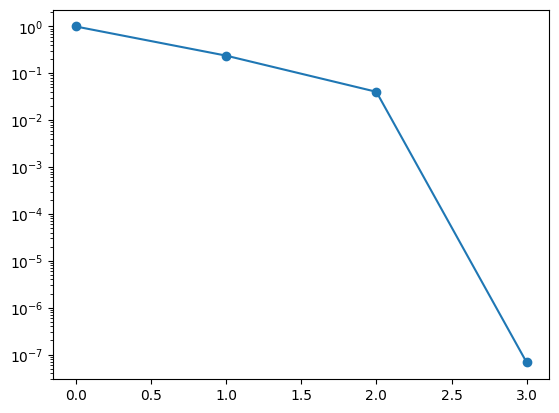

In [4]:
plt.plot(losses,"-o")
plt.yscale('log')

# Noisy

In [ ]:
V_dagger_V_noisy = __estimate_V_dagger_V(instance, ansatz_tree,loss_type=None, backend='qiskit-noisy', shots=10000, optimization_level=2,noise_level_two_qubit=0.014, noise_level_one_qubit=0.0002, readout_error=0.007)
q_noisy=__estimate_q(instance, ansatz_tree, backend='qiskit-noisy', shots=10000, optimization_level=2,noise_level_two_qubit=0.02, noise_level_one_qubit=0.0002, readout_error=0.007)


Hadamard tests V_dagger_V Progress:   2%|▏         | 2/90 [00:21<15:27, 10.53s/it]

In [ ]:
losses_noisy=[]
for depth in tqdm(range(len(ansatz_tree))):
    Q, r = __reshape_to_Q_r(V_dagger_V_noisy[:depth+1:,:depth+1:], q_noisy[:depth+1:])
    loss, _ = solve_combination_parameters(Q, r, which_opt='ADAM')
    losses_noisy+=[loss]

In [ ]:
plt.plot(losses,"-o")
plt.plot(losses_noisy,"-o")
# plt.yscale('log')

In [ ]:
losses_noisy

In [ ]:
import time
import numpy as np

# Generate the filename with the current time
filename = f"loss_data_{int(time.time())}.txt"

# Save the data
with open(filename, "w") as f:
    f.write("Losses:\n")
    np.savetxt(f, losses, fmt="%.6f")  # Save losses with 6 decimal precision
    f.write("\nLosses Noisy:\n")
    np.savetxt(f, losses_noisy, fmt="%.6f")

print(f"Data saved to {filename}")
